In [ ]:
%pip install pandas
%pip install transformers
%pip install accelerate
%pip install seaborn
%pip install scikit-learn

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=4

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=4


In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
import pandas as pd
df = pd.read_csv('test_subset.csv')


In [4]:
#text set for getting the results from LLM
texts = list(df.text)

### Chat propmt used to get the labels of sequences using the fine-tuned model

In [5]:
load_in_4bit = True
dtype = None
if True:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "Hina541/fine-tuned-MetaLlamaModelSequence_latest_15Epochs", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = 512,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model)
prompt = f"Classify the sentiment of each text into ONE of the three classes: neutral, negative or positive. Text:"

answers = []
#text_list =[ "Ukraine deckt auf 😂😂😂😂😂\nDie mussten was sagen, nicht das man denkt der Staat wäre korrupt und es würde keinen Kampf dagegen geben ☝️\n\nKorrupt bleibt korrupt - auch die, da wird sich auch nichts änder 😆",'Nur Politiker wollen Krieg ! Was wenn keiner mehr Bock hat für diese 5 Politiker zu sterben warum drehen wir den Spieß nich einfach um ? 😕 frage für n Freund']
for text in texts:
    chat_template = [{"role" : "user", "content" : f"{prompt} {text}"}]

    chat_prompt = tokenizer.apply_chat_template(chat_template, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer.encode(chat_prompt, add_special_tokens=False, return_tensors="pt", max_length=512, padding=True)
    outputs = model.generate(input_ids=inputs.to("cuda"), max_new_tokens = 512)
    answer = tokenizer.decode(outputs[0])
    answers.append(answer)
    #print(answer)
print(len(answers))


/ltstorage/home/1samreen/miniconda3/envs/new_saint_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.44.0.
   \\   /|    GPU: NVIDIA RTX A6000. Max memory: 47.318 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.6. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unsloth 2024.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


300


### Pre-processing the results in the desired format , so as to evaluate the accuracy

In [ ]:
labels = []
for answer in answers:
    label= answer.split('<|end_header_id|>')[-1][:-10].strip()
    labels.append(label)


In [12]:
df['predicted_sentiment_llm'] = labels

In [13]:
#getting only the classes 'Negative','Positive,'and 'Neutral' and ignoring other classes if any other are present
df = df[('negative' == df['predicted_sentiment_llm']) |  ('positive' == df['predicted_sentiment_llm']) | ('neutral' == df['predicted_sentiment_llm'])]
df = df.reset_index(drop=True)
for i in range(len(df)):
    df.loc[i,'predicted_sentiment_llm'] = str(df['predicted_sentiment_llm'][i]).lower()
len(df)

300

In [14]:
df

,user,instance_id,text,sentiment,negative object_spans,negative spans,positive spans,positive object_spans,predicted_sentiment_llm
0,ekaterini@gmail.com,898,Nur Politiker wollen Krieg ! Was wenn keiner m...,negative,"['Politiker ', 'Krieg ']","['Was wenn keiner mehr Bock hat', 'zu sterben'...",...,...,negative
1,ekaterini@gmail.com,833,Der Klimawandel ist ein völlig normaler Prozes...,positive,...,...,völlig normaler Prozess,Klimawandel,negative
2,ekaterini@gmail.com,1428,Man will die Stadthalle für einen #Bürgerdialo...,negative,Demokraten,"['missliebige Partei ', 'Was denken die']",...,...,negative
3,ekaterini@gmail.com,431,"Besonders beliebt ist auch ""Wir mussten währen...",negative,Corona,die während Corona auch gern auf die Maske ver...,...,...,negative
4,ekaterini@gmail.com,1315,Die USA sollten sich mäßigen Israel zu ermahne...,positive,...,...,handelt moralisch richtig,"['Israel ', 'Israel ']",positive
...,...,...,...,...,...,...,...,...,...
295,ekaterini@gmail.com,1134,Auch Israel begeht Kriegsverbrechen an der Ziv...,negative,Israel,"['begeht Kriegsverbrechen', 'aber Kritik an Is...",...,...,negative
296,ekaterini@gmail.com,127,Sogenannte Zivilisten? geht's noch?,negative,...,geht's noch?,...,...,negative
297,ekaterini@gmail.com,366,"Ganz normal, dass wir in Zeiten der Klimakrise...",negative,Klimakrise,"['hypokapitalistischen', 'Nice one, Humanity',...",...,...,negative
298,ekaterini@gmail.com,473,Kleine Nachhilfe: Ein paar hunderttausend Grün...,negative,Grüne,eine Klatsche bekommen habt,...,...,negative


In [15]:
correct_predictions = 0
for i in range(len(df)):
    if df['sentiment'][i] == df['predicted_sentiment_llm'][i]:
        correct_predictions += 1
print('correct predictions:',correct_predictions)

correct predictions: 246


In [17]:
Accuracy = (correct_predictions/len(df))*100
print('Accuracy of Metal Llama after fine tuning is',Accuracy, '%')

Accuracy of Metal Llama after fine tuning is 82.0 %


In [18]:
df.to_csv('ResultsAfterFineTuning_SequnceClassification_MetaLLama15Epochs.csv', index=False)

### Generating a Confusion matrix

Text(0.5, 1.0, 'Confusion Matrix for Meta Llama(fine-tuned)')

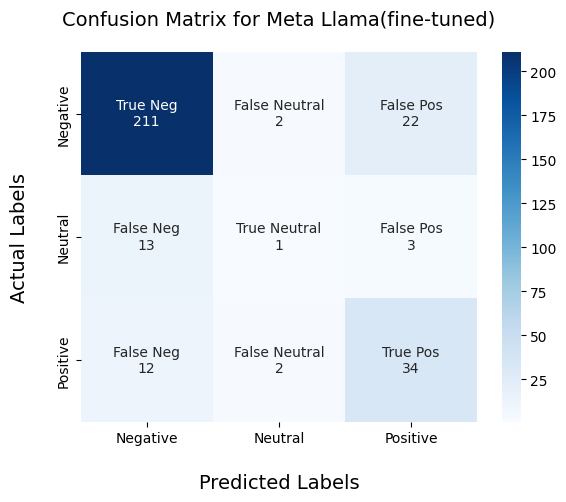

In [19]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(df['sentiment'], df['predicted_sentiment_llm'])

group_names = ['True Neg','False Neutral','False Pos','False Neg','True Neutral','False Pos','False Neg','False Neutral','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(3, -1, order='C')

ax = sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel("Predicted Labels", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])

ax.set_ylabel("Actual Labels", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])

ax.set_title("Confusion Matrix for Meta Llama(fine-tuned)", fontsize=14, pad=20)